# Rate equations for Gas Laser

In [2]:
using PyPlot
using Distributions
using Calculus
using Cubature
using Interact


### constant parameters:

In [3]:
const radius = 0.25; # radius is in cm
const L = 15; # cm

const h = 6.626068e-34; # in Js
const c = 3e8; # in m/s
const ev = 1.60217646e-19; # in J
const kB = 8.617342e-5; # in eV/K
const T = 300; # in K
const kBT = kB*T*8065.73; # in cm-1
const M = 35; # molecular mass in AMU
const norm_time = 1e6; # normalizing to microsec

## The following constants can be found in p189 Henry's dissetation. 
const σ_GKC = 44; # in angstrom^2. Gas Kinetic Collision cross section.
const σ_DD = 320; # in angstrom^2. Dipole-dipole cross section.
const σ_SPT = 137; # in angstrom^2. SPT cross section.
const σ_36 = 1.61; # in angstrom^2. v3->v6 cross section.
# σ_36 is obtained by fitting the result to the experimental result.
const σ_VS = 21; # in angstrom^2. V-swap cross section.

# define kvs (bimolecular collisions); neglected firstly;
const v = 205*sqrt(T/M); # in m/sec. p5 Henry's dissertation;
const kvs = v*σ_VS *(1e-10)^2/norm_time; # in m^3/microsec
# const kvs = 0;
# oscillation energy levels:
const EG = 0;
const E3 = 1050;
const E6 = 1200;
const E23 = 2100;
const E36 = 2250;
const E26 = 2400;

# Boltzmann distribution:
const Q = exp(EG) + 
          exp(-E3/kBT) + 
          2*exp(-E6/kBT) + 
          exp(-E23/kBT) + 
          exp(-E36/kBT) + 
          exp(-E26/kBT);
const f_G = exp(EG)/Q;
const f_3 = exp(-E3/kBT)/Q;
const f_6 = 2*exp(-E6/kBT)/Q; # factor of 2: double degeneracy of V_6
const f_23 = exp(-E23/kBT)/Q;
const f_36 = exp(-E36/kBT)/Q;
const f_26 = exp(-E26/kBT)/Q;

const C3L = 0.005926302;  # degeneracy included. Feb 7th 2015 email from Henry.
const C4L = 0.007374597;
const C5L = 0.008652703;
const C4U = C4L;
const C5U = C5L;

const g_L = 9.0;
const g_U = 11.0;

const NA = 6.0221413e23;

##################### frequency constants ############################
const f₀ = 31.042748176e12; # in Hz. Data from Laser Line Number.pptx
const f_offset = 30e6;
const f_pump = f₀ + f_offset;
const f_dir_lasing = 245.38e9;
const f_ref_lasing = 248.56e9;
const Δ_f₀D = 3.58e-7*f₀*sqrt(T/M); # in Hz. p26 Henry's dissetation;

const f_range = 5*Δ_f₀D;

const n_rot = 18;
const n_vib = 12;

const mu0 = 4e-7*pi
const eps0 = 8.85e-12
const mode_num = 1 # 1: TE01 / 2: TE12 / 3: TE02 / 4: TE22 / 5: TE11 / 6: TE21 / 7: TM01 / 8: TM11
const p_library = [3.83, 5.33, 7.02, 6.71, 1.84, 3.05, 2.4, 3.83] #zeros of Bessel functions.
const n0 = 1.0 # refractive index
const t_spont = 100
const Δν_THz = 25e6 ;

In [57]:
9.4e13/32e6 * 0.2756^2 *16/45 * exp(-log(2)*((f_pump-f₀)/Δ_f₀D)^2)

79331.15377777777

In [58]:
8pi^2 * 1e7 * 1e-36 * sqrt(log(2)/pi) / (3*h^2*1e14*3e10*1e6)

9.3858420217051e7

## define parameter type

In [4]:
type parameter
    pressure::Real
    power::Real
    num_layers::Int64
    
    ntotal::Real
    k63::Real
    k36::Real
    k3623::Real
    k2336::Real
    k2636::Real
    k3626::Real
    kro::Real

    Δ_fP::Real
    Δ_f_Rabi::Real
    Δ_f_NT::Real
    
    num_freq::Int64
    df::Real
    f_dist_end::Array
    f_dist_ctr::Array
    velocity::Array
    f_dist_dir_lasing::Array
    gauss_dist::Array
    SHB::Array
    fp_lasing::Array
    pumpR::Array

    Δr::Real
    r_int::Array

    kwall::Array
    
    MFP::Real

    D::Real

    k98_G::Real
    k87_G::Real
    k76_G::Real
    k65_G::Real
    k54_G::Real
    k43_G::Real
    k32_G::Real
    k21_G::Real
    
    k89_G::Real
    k78_G::Real
    k67_G::Real
    k56_G::Real
    k45_G::Real
    k34_G::Real
    k23_G::Real
    k12_G::Real

    k98_3::Real
    k87_3::Real
    k76_3::Real
    k65_3::Real
    k54_3::Real
    k43_3::Real
    k32_3::Real
    k21_3::Real
    
    k89_3::Real
    k78_3::Real
    k67_3::Real
    k56_3::Real
    k45_3::Real
    k34_3::Real
    k23_3::Real
    k12_3::Real
    
    k1a::Real
    k2a::Real
    k3a::Real
    k4a::Real
    k5a::Real
    k6a::Real
    k7a::Real
    k8a::Real
    k9a::Real
    k10a::Real
    k11a::Real
    k12a::Real
    k13a::Real
    k14a::Real
    k15a::Real
    k16a::Real
    k17a::Real
    k18a::Real

    niter::Int64
end

### wall rate functions

In [52]:
include("./src/wallrates.jl")
include("./src/Lorentz_distribution.jl")
include("./src/Q_select.jl")
include("./src/OPFIR_compute_parameters.jl")
include("./src/OPFIR_compute_rhs.jl")
include("./src/OPFIR_compute_row_col_val.jl")
include("./src/OPFIR_fixedpoint.jl")
include("./src/anderson_accel.jl")
include("./src/OPFIR_func.jl")
include("./src/post_plotting.jl")
include("./src/post_gain.jl")
include("./src/population_inv.jl")
include("./src/Sherman_Morrison.jl")

SM_solve (generic function with 1 method)

In [53]:
pressure_list = [500] # in mTorr;
power = 10
num_layer = 40
U_gain = zeros(size(pressure_list))
sol = 0
for i in 1:length(pressure_list)
    pressure = pressure_list[i]
    sol = OPFIR_func(pressure, power, num_layer, 30);
    U_gain[i] = OPFIR_gain(sol[1], sol[2])
end
println(U_gain)
# post_plotting(sol[1], sol[2], sol[1].pressure, sol[1].power, 10);

matrix size is 125760
norm of sol diff = 1.0
norm of sol diff = 4.246002599336366e-6
norm of sol diff = 2.0634365519001666e-6
norm of sol diff = 7.189496152427745e-7
[1.168625066475963e-5]


In [54]:
println(Δ_f₀D)
println(sol[1].Δ_fP)
println(sol[1].kwall)

3.2536422104982965e7
7.5e6
[1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 1.0e-10 0.10727586836178747 2.3268029431369492]


In [ ]:
include("population_inv.jl")
inv = zeros(sol[1].num_layers,1)
for ri in 1:sol[1].num_layers
    inv_U = get_inv_U(sol[1], sol[2], ri) # inversion as a function of velocity
    inv[ri] = sum(inv_U .* sol[1].fp_lasing)
end
plot(inv)


In [ ]:
plot(sol[1].fp_lasing)

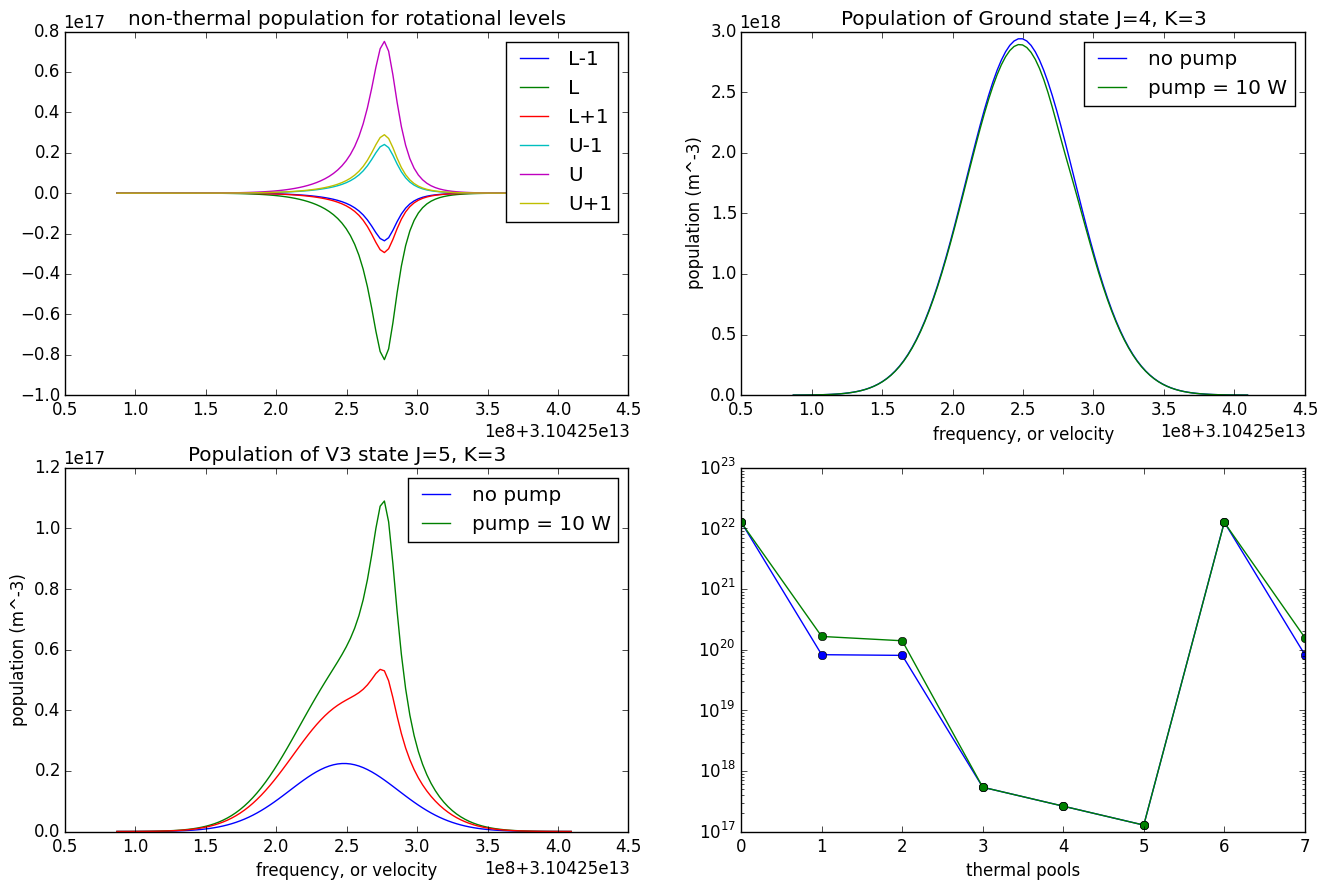

12-element Array{Float64,1}:
 -1.42422e20
  8.2664e19 
  5.97572e19
 -2.19566e10
 -1.06941e10
 -5.20867e9 
 -1.33609e20
  7.56536e19
  5.79543e19
 -7.34162e12
 -1.02189e13
 -5.49604e13

In [13]:
include("./src/post_plotting.jl")
figure(figsize=(16,10))
post_plotting(sol[1], sol[2], sol[1].pressure, sol[1].power, 50)

In [ ]:
sub_sum = zeros(sol[1].num_layers,1);
solution = sol[2];
ri = sol[1].r_int;
for i = 1:sol[1].num_layers
    index1 = (18*sol[1].num_freq + n_vib) * (i-1) + 1;
    index2 = (18*sol[1].num_freq + n_vib) * i;
    sub_sum[i] = sum(solution[index1:index2]) * ri[i];
end
sum((sub_sum))

In [ ]:
include("post_plotting.jl")
include("population_inv.jl")
figure(figsize=(6,4))
hold
plot_inv_U(sol[1], sol[2], 30)
plot_inv_U(sol[1], sol[2], 1)
plot_f0()
legend(["close to the wall", "away from the wall"], fontsize=10)

figure(figsize=(6,4))
hold
plot_inv_L(sol[1], sol[2], 30)
plot_inv_L(sol[1], sol[2], 1)
plot_f0()
legend(["close to the wall", "away from the wall"], fontsize=10)

In [ ]:
include("population_inv.jl")
# 12 is U and 2 is L
# plot(get_Nu_vs_freq_layer(sol[1], sol[2], 30))
# hold
# plot(get_rot_vs_freq_layer(sol[1], sol[2], 11, 30))
freq = sol[1].f_dist_ctr;
figure(figsize=(6,4))
title("with bi-molecular collision, pressure = $pressure")
plot([f₀, f₀], [0, 1e15], "r--")
hold
plot([f_pump, f_pump], [0, 1e15], "r--")
plot(freq, get_inv_U(sol[1], sol[2], 30))
hold
plot(freq, get_inv_U(sol[1], sol[2], 1))
figure(figsize=(6,4))
plot([f₀, f₀], [0, 1e15], "r--")
hold
plot([f_pump, f_pump], [0, 1e15], "r--")
plot(freq, get_inv_L(sol[1], sol[2], 30))
hold
plot(freq, get_inv_L(sol[1], sol[2], 1))

In [ ]:
include("population_inv.jl")
# 12 is U and 2 is L
# plot(get_Nu_vs_freq_layer(sol[1], sol[2], 30))
# hold
# plot(get_rot_vs_freq_layer(sol[1], sol[2], 11, 30))
freq = sol[1].f_dist_ctr;
figure(figsize=(6,4))
title("with bi-molecular collision")
plot([f₀, f₀], [0, 1e15], "r--")
hold
plot([f_pump, f_pump], [0, 1e15], "r--")
plot(freq, get_inv_U(sol[1], sol[2], 30))
hold
plot(freq, get_inv_U(sol[1], sol[2], 1))
figure(figsize=(6,4))
plot([f₀, f₀], [0, 1e15], "r--")
hold
plot([f_pump, f_pump], [0, 1e15], "r--")
plot(freq, get_inv_L(sol[1], sol[2], 30))
hold
plot(freq, get_inv_L(sol[1], sol[2], 1))

In [ ]:
include("population_inv.jl")

In [ ]:
plot(get_inv_L(sol[1], sol[2], 30))
hold
plot(get_inv_L(sol[1], sol[2], 1))

In [ ]:
include("OPFIR_compute_parameters.jl")
para = OPFIR_compute_parameters(200, 10, 2);

In [50]:
(c/f_dir_lasing)^2/(8*pi*n0^2*t_spont)/Δν_THz*0.01

2.378944536284192e-19

In [59]:
data = [-2.59389E-07	6.50493E-07	1.56663E-06	6.56941E-06	1.10262E-05	2.04707E-05	3.49507E-05	6.34899E-05	9.35525E-05
-1.15402E-06	1.93269E-06	5.0698E-06	2.26972E-05	3.90591E-05	7.54739E-05	0.000134569	0.000254909	0.000377915
-3.12424E-06	3.08661E-06	9.40991E-06	4.51333E-05	7.85506E-05	0.000153587	0.000276246	0.000522377	0.000759233
-6.80747E-06	2.8168E-06	1.26088E-05	6.77977E-05	0.000119202	0.000233707	0.000417495	0.00076924	0.00108018
-1.30142E-05	-5.2031E-07	1.21661E-05	8.31913E-05	0.000148613	0.000291773	0.00051396	0.000911578	0.00122975
-2.27291E-05	-8.79908E-06	5.30418E-06	8.34945E-05	0.000154377	0.000305736	0.000530612	0.000902145	0.00116727
-3.71454E-05	-0.000024293	-1.13278E-05	5.97019E-05	0.000122866	0.000253919	0.000439107	0.000718005	0.000888068
-5.76593E-05	-4.96198E-05	-4.15402E-05	2.18669E-06	0.00004031	0.000117082	0.000219628	0.000353639	0.00040446
-8.55687E-05	-8.77035E-05	-8.98204E-05	-0.000100812	-0.000109832	-0.000126937	-0.000150332	-0.000204081	-0.000288379
-0.000121748	-0.000140626	-0.000159357	-0.000256794	-0.000336806	-0.000486541	-0.000671987	-0.00094118	-0.00116665]

10x9 Array{Float64,2}:
 -2.59389e-7    6.50493e-7    1.56663e-6   …   6.34899e-5    9.35525e-5 
 -1.15402e-6    1.93269e-6    5.0698e-6        0.000254909   0.000377915
 -3.12424e-6    3.08661e-6    9.40991e-6       0.000522377   0.000759233
 -6.80747e-6    2.8168e-6     1.26088e-5       0.00076924    0.00108018 
 -1.30142e-5   -5.2031e-7     1.21661e-5       0.000911578   0.00122975 
 -2.27291e-5   -8.79908e-6    5.30418e-6   …   0.000902145   0.00116727 
 -3.71454e-5   -2.4293e-5    -1.13278e-5       0.000718005   0.000888068
 -5.76593e-5   -4.96198e-5   -4.15402e-5       0.000353639   0.00040446 
 -8.55687e-5   -8.77035e-5   -8.98204e-5      -0.000204081  -0.000288379
 -0.000121748  -0.000140626  -0.000159357     -0.00094118   -0.00116665 

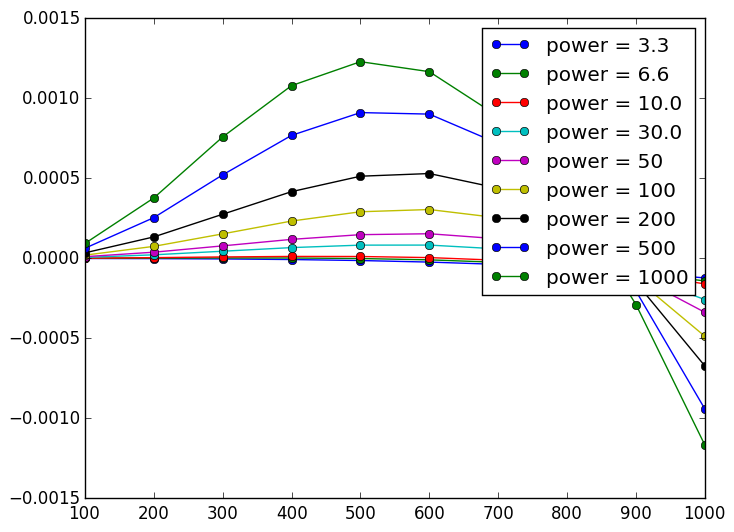

PyObject <matplotlib.legend.Legend object at 0x319d5e050>

In [63]:
power_list = [3.3 6.6 10 30 50 100 200 500 1000];
pressure_list = linspace(100,1000,10)
for i in 1:9
    plot(pressure_list, data[:,i],"o-")
    hold
end
legend(["power = 3.3","power = 6.6","power = 10.0", "power = 30.0", "power = 50", "power = 100", "power = 200", "power = 500", "power = 1000"])

In [62]:
16/45*0.2756^2 / 0.098^2

2.811989819056874